### QPSK Full Synchronization System

The *QPSK.ipynb* notebook demonstrates a full quadrature phase shift keying transmitter and receiver architecture yet assumes that the two systems are completely synchronized in both sample timing and carrier phase. This system is architecture is shown below in figure 1.

<div style="text-align: center;">
    <img src="./images/QPSK_Synchronized/full_system_sync_diagram.png" alt="" width="900" />
    <p style="text-align: center;">Figure 1: QPSK Receiver Architecture</p>
</div>

In practical systems, the exact settings of the transmitter's oscillators are unknown; only a general estimation is available. The Phase-Locked Loop (PLL) subsystem, as detailed in the PLL.ipynb notebook, demonstrates the process of correcting carrier phase and frequency offsets to achieve synchronized demodulation. The Symbol Clock Synchronizer (SCS) subsystem, described in the SCS.ipynb notebook, outlines the process of correcting sample timing offsets to ensure that the sample selection process is synchronized with the sample rate used by the transmitter. When combined, these two subsystems allow a receiver to lock onto a receive signal and obtain the transmitted message admist the syncrhonization offsets. The receiver architecture including both the PLL and SCS subsystems is shown below in figure 2.

<div style="text-align: center;">
    <img src="./images/QPSK_Synchronized/full_system_diagram.png" alt="" width="1000" />
    <p style="text-align: center;">Figure 2: Synchronized QPSK Receiver Architecture</p>
</div>

&nbsp;
### Transmitter

The QPSK transmitter can be simulated similarly to that in the QPSK example (see *QPSK.ipynb*), with the addition of predefined synchronization offsets. This process is summarized below.

#### System Configuration

First, the developed signal processing library must be imported as well as plotting and linear algebras libraries to aid in later visualization of the system's internal variables.

In [1]:
from helper_functions import sp_library as sp
import numpy as np
import matplotlib.pyplot as plt

Next, before the transmitter can be described, a set of system parameters must be configured to define the design. QPSK has already been selected as the modulation type, and the remaining system parameters are set below, including the corresponding constellation map, system noise $ N_o $, sample rate $ f_s $, carrier frequency $ f_c $, and the input message.

In [49]:
qpsk_constellation = [[complex( np.sqrt(1) +  np.sqrt(1)*1j), 3], 
                      [complex( np.sqrt(1) + -np.sqrt(1)*1j), 2], 
                      [complex(-np.sqrt(1) + -np.sqrt(1)*1j), 0], 
                      [complex(-np.sqrt(1) +  np.sqrt(1)*1j), 1]]
noise = 2 * (10 ** -4)
fs = 8 # sample rate
fc = .25 * fs # carrier frequency

#### Bit to Symbol Mapping

In [50]:
input_message_ascii = "this is a qpsk transceiver test!"

# mapping the ascii characters to binary
input_message_bins = ''.join(sp.string_to_ascii_binary(input_message_ascii))

# grouping the binary into blocks of two bits
input_message_blocks = [input_message_bins[i:i+2] for i in range(0, len(input_message_bins), 2)]

# mapping each block to a symbol in the constellation
input_message_symbols = [int(bin2, 2) for bin2 in input_message_blocks]

#### Unique Word and Header

In [85]:
# adding unqiue word to symbols
unique_word = [0, 1, 2, 3, 0, 1, 2, 3]
phase_ambiguities = {
    "01230123": 0,
    "20312031": np.pi/2,
    "32103210": np.pi,
    "13021302": 3*np.pi/2
}

input_message_symbols = unique_word + input_message_symbols

bits_to_amplitude = {bit: amplitude for amplitude, bit in qpsk_constellation}

# inphase channel symbol mapping
xk = np.real([bits_to_amplitude[symbol] for symbol in input_message_symbols])

# quadrature channel symbol mapping
yk = np.imag([bits_to_amplitude[symbol] for symbol in input_message_symbols])

# adding header to each channel
header = [1,0] * 50
xk = np.concatenate([header, xk])
yk = np.concatenate([header, yk])

#### Upsampling

In [69]:
xk_upsampled = sp.upsample(xk, fs)
yk_upsampled = sp.upsample(yk, fs)

#### Introducing a Timing Offset

A timing offset is introduced to the upsampled symbols in the transmitter using two methods. The first method involves offsetting the signal's sample timings by interpolating and selecting an intermediate periodic sample to represent the entire signal. The second method creates an offset in the symbol spacing by removing a small segment of the input samples, which the SCS will later correct. Both methods can be adjusted in the following example.

In [70]:
timing_offset = 0.0
sample_shift = 0

xk_upsampled = sp.clock_offset(xk_upsampled, fs, timing_offset)[sample_shift:]
yk_upsampled = sp.clock_offset(yk_upsampled, fs, timing_offset)[sample_shift:]

#### Pulse Shaping

In [71]:
length = 64
alpha = 0.10
pulse_shape = sp.srrc(alpha, fs, length)

xk_pulse_shaped = np.real(sp.convolve(xk_upsampled, pulse_shape, mode="same")[1:])
yk_pulse_shaped = np.real(sp.convolve(yk_upsampled, pulse_shape, mode="same")[1:])

print(f"\nFilter Length: {length} samples")
print(f"Message Length: {alpha} percent")
print(f"Sample Rate: {fs} samples per symbol\n")


Filter Length: 64 samples
Message Length: 0.1 percent
Sample Rate: 8 samples per symbol



#### Digital Modulation

In [72]:
s_rf = (
    np.sqrt(2) * np.real(sp.modulate_by_exponential(xk_pulse_shaped, fc, fs, noise=noise)) +
    np.sqrt(2) * np.imag(sp.modulate_by_exponential(yk_pulse_shaped, fc, fs, noise=noise))
)

&nbsp;
### Receiver

A small phase and frequency offset will be added to the demodulation module which removes the synchronization between the transmitter and receiver modules. The matched filtering and downsampling are kept the same as in the *QPSK.ipynb* notebook and are further discussed there.

#### Digital Demodulation

In [73]:
fc_offset = 0.0005
phase_offset = 3 * np.pi

r_nT = np.sqrt(2) * sp.modulate_by_exponential(s_rf, fc + fc_offset, fs) * np.exp(1j * phase_offset)
xr_nT = np.real(r_nT)
yr_nT = np.imag(r_nT)

#### Match Filtering

In [74]:
xr_nT_match_filtered = np.real(sp.convolve(xr_nT, pulse_shape, mode="same")[1:])
yr_nT_match_filtered = np.real(sp.convolve(yr_nT, pulse_shape, mode="same")[1:])

#### Down Sampling

The matched filtered signal represented by $N$ samples per symbol is now downsampled by a factor of $\frac{N}{2}$ producing a 2 samples per symbol representation.

In [75]:
xr_nT_downsampled = sp.downsample(xr_nT_match_filtered, int(fs/2))
yr_nT_downsampled = sp.downsample(yr_nT_match_filtered, int(fs/2))
r_nT = (xr_nT_downsampled + 1j* yr_nT_downsampled)

An excerpt from the downsampled signal as well as the complex constellations are plotted to illustrate the current state of the receive samples.

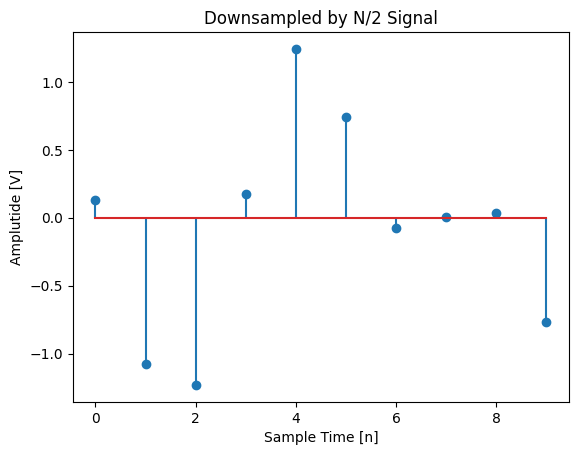

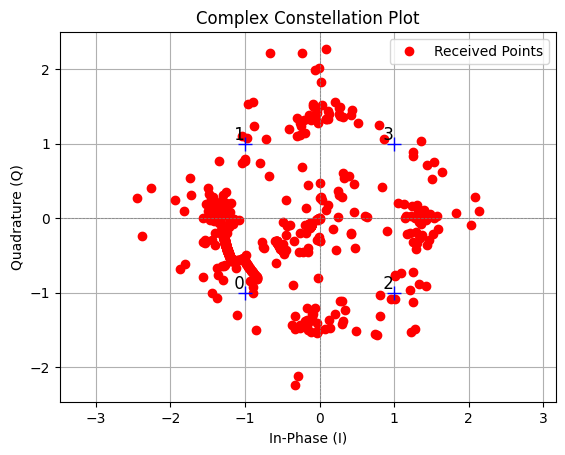

In [76]:
plt.figure()
plt.stem(yr_nT_downsampled[len(header)*2:(len(header)+5)*2])
plt.title("Downsampled by N/2 Signal")
plt.xlabel("Sample Time [n]")
plt.ylabel("Amplutide [V]")
plt.show()

# plot the downsampled constellation
sp.plot_complex_points(r_nT, constellation=qpsk_constellation)

#### Unique Word Resolution

To identify the received unique word and properly adjust the received constellations by the corresponding phase ambiguity, a shift register is used to search for the unique word while the PLL operates. Each incoming sample is inserted into the register, which is then checked against the phase ambiguity lookup table for a match. This process continues until a match is found, at which point the DDS output is adjusted to account for the identified ambiguity.

In [77]:
uw_register = ['0', '0', '0', '0', '0', '0', '0', '0']
uw_flag = False
uw_offset = 0 # initial unique word offset

#### Measuing SCS and PLL Gain

For both the PLL and SCS subsystems, a loop bandwidth and damping factor are defined. The systems are then run on the raw input samples to determine the maximum outputs of their respective loop filters. These maximum values are used to normalize the outputs, represented as the gain factor $G$ in the module diagrams.

In [78]:
pll_loop_bandwidth = (fc/fs) * 0.06
pll_damping_factor = 1/np.sqrt(2)

scs_loop_bandwidth = (fc/fs) * 0.03
scs_damping_factor = 1/np.sqrt(2)

pll = sp.PLL(sample_rate=2, loop_bandwidth=pll_loop_bandwidth, damping_factor=pll_damping_factor, open_loop=True)
scs = sp.SCS(samples_per_symbol=2, loop_bandwidth=scs_loop_bandwidth, damping_factor=scs_damping_factor, open_loop=True)

In [79]:
pll_max_lf_output = 0
scs_max_lf_output = 0
for i in range(len(r_nT)):
    pll_lf_output = pll.insert_new_sample(r_nT[i], i)
    scs_lf_output = scs.insert_new_sample(r_nT[i])

    if pll_lf_output > pll_max_lf_output:
        pll_max_lf_output = pll_lf_output

    if scs_lf_output > scs_max_lf_output:
        scs_max_lf_output = scs_lf_output

pll_gain = pll_max_lf_output
scs_gain = 1/scs_max_lf_output

print(f"\nPLL Measured System Gain: {pll_gain}\n")
print(f"\nSCS Measured System Gain: {scs_gain}\n")


PLL Measured System Gain: 0.05957111115167022


SCS Measured System Gain: 33.26133807591992



The PLL and SCS modules are then reinstantiated with the measured gain values input as parameters for each and run using the input samples. A number of arrays are also defined to track internal records throughout the simulation.

In [80]:
pll = sp.PLL(sample_rate=2, loop_bandwidth=pll_loop_bandwidth, damping_factor=pll_damping_factor, gain=pll_gain)
scs = sp.SCS(samples_per_symbol=2, loop_bandwidth=scs_loop_bandwidth, damping_factor=scs_damping_factor, gain=scs_gain, invert=True)

detected_constellations = []
rotated_corrected_constellations = []
pll_error_record = []

dds_output = np.exp(1j * 0) # initial pll rotation

In [81]:
for i in range(len(r_nT)):
    # perform ccw rotation
    r_nT_ccwr = r_nT[i] * dds_output * np.exp(1j * uw_offset)
    
    # correct clock offset
    corrected_constellation = scs.insert_new_sample(r_nT_ccwr)
    if corrected_constellation is not None:
        rotated_corrected_constellations.append(corrected_constellation)

        # phase error calculation
        detected_symbol = sp.nearest_neighbor([corrected_constellation], qpsk_constellation)[0]
        detected_constellation = bits_to_amplitude[detected_symbol]
        detected_constellations.append(detected_constellation)
        
        # update unquie word register
        uw_register.pop(0)
        uw_register.append(str(detected_symbol))

        if uw_flag == False:
            received_unique_word = sp.check_unique_word(uw_register, phase_ambiguities=phase_ambiguities)
            if received_unique_word is not None:
                uw_offset = received_unique_word
                uw_flag = True
        
        # calculating phase error
        phase_error = pll.phase_detector(corrected_constellation, detected_constellation)
        pll_error_record.append(phase_error)

        # feed into loop filter
        loop_filter_output = pll.loop_filter(phase_error)

        # feed into dds
        pll.dds(i, loop_filter_output)

        # generate next dds output
        dds_output = np.exp(1j * pll.get_current_phase())

The simulation results and internal records are plotted below to illustrated the subsystems performance.

Phase Ambiguity Rotation: 180.0 deg



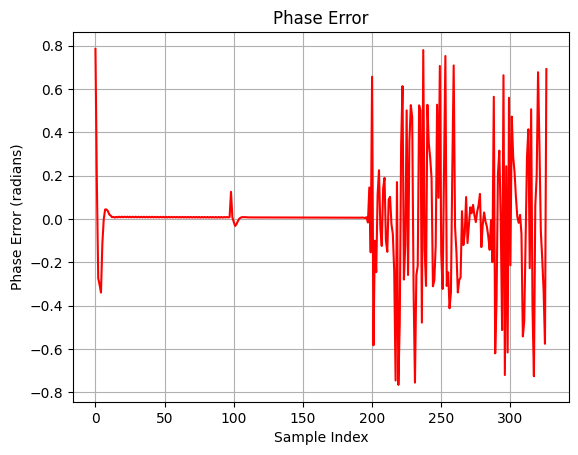

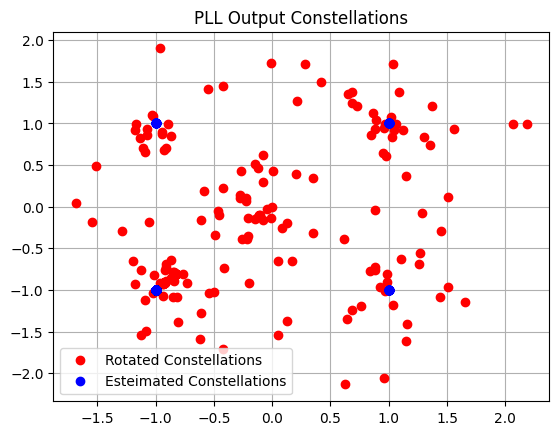

In [82]:
print(f"Phase Ambiguity Rotation: {np.degrees(uw_offset)} deg\n")
plt.figure()
plt.plot(pll_error_record, label='Phase Error', color='r')
plt.title('Phase Error')
plt.xlabel('Sample Index')
plt.ylabel('Phase Error (radians)')
plt.grid()
plt.show()

plt.title("PLL Output Constellations")
plt.plot(np.real(rotated_corrected_constellations), np.imag(rotated_corrected_constellations), 'ro', label="Rotated Constellations")
plt.plot(np.real(detected_constellations), np.imag(detected_constellations), 'bo',  label="Esteimated Constellations")
plt.legend()
plt.grid(True)
plt.show()

#### Symbol Decision

The now downsampled to 1 sample per symbol receive signal is ready to be mapped back from constellation points to symbols via a nearest neighbor algorithm, this process is discussed more thoroughly in the *QPSK.ipynb* notebook.

In [83]:
detected_symbols = sp.nearest_neighbor(detected_constellations[len(header)+len(unique_word)+1:], qpsk_constellation)

error_count = sp.error_count(input_message_symbols[len(unique_word):], detected_symbols)
print(f"Transmission Symbol Errors: {error_count}")
print(f"Bit Error Percentage: {round((error_count * 2) / len(detected_symbols), 2)} %")

Transmission Symbol Errors: 34
Bit Error Percentage: 0.58 %


Finally, the estimated receive symbols can now be converted back to binary representations and then grouped into ascii characters.

In [84]:
detected_bits = []
for symbol in detected_symbols:
    detected_bits += ([*bin(symbol)[2:].zfill(2)])

message = sp.bin_to_char(detected_bits)
print(message)

r6uX2hY2hy(<t<zhX{\aix<Y<H]I0t
